# 76 Cereal Brands, a Fascinating Head-to-Head

A reader sent in a fun ask: Can you do an analysis comparing cereal brands? It's hard not to feel nostalgic seeing boxes of Apple Jacks, Froot Loops, and Cap'n'Crunch lined up on the shelf so we were excited to explore. We came a across a data set with >75 cereal brands across major manufacturers, including Nabisco, Quaker Oats, Kellogg's, Ralston Purina, General Mills, and Post (https://perso.telecom-paristech.fr/eagan/class/igr204/datasets). We'll explore 3 questions:   

**Question 1**: Is Consumer Reports average rating (0-100) related to sugar, calories, and fiber per serving?
<br>**Question 2**: What are the differences in sugar and calorie per serving and average rating by manufacturer?
<br>**Question 3**: Is sugar per serving related to shelf position (from bottom)? 

We plot stratified line plots, box plots, histograms, and heatmaps using seaborn and work with our dataframe using .get_numeric_data, .replace, .groupby, and .nlargest to reveal some fascinating insights:

**Insight 1**: Consumers rate cereal brands with higher sugar and calorie content lower and those with higher fiber content higher, with Pearson correlations that affirm these associations.
<br>**Insight 2**: Among manufacturers, Nabisco and Quaker Oats have lower median sugar and calories per serving, while drawing higher average ratings from consumers. Vice versa for Post. 
<br>**Insight 3**: The middle shelf, most visible and accessible to kids, houses brands with the highest median, 25th percentile, and 75th percentile sugar per serving and mean sugar per serving roughly twice that of the bottom shelf.  

In order to get to more statistically significant conclusions and models, it would be important to get an expanded sample size and better understand how the data was collected and where it came from. 

In [1]:
# Import relevant libraries
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

In [2]:
# The code was removed by Watson Studio for sharing.

In [3]:
# Set view options to prevent columns and rows being cut off 
pd.set_option("display.max_columns", 100)
pd.set_option("display.max_rows", 100)

In [4]:
# Read in data
cereal = pd.read_csv(body)

# Take a look at the first few rows
cereal.head()

,name,mfr,type,calories,protein,fat,sodium,fiber,carbo,sugars,potass,vitamins,shelf,weight,cups,rating
0,100% Bran,N,C,70,4,1,130,10.0,5.0,6,280,25,3,1.0,0.33,68.402973
1,100% Natural Bran,Q,C,120,3,5,15,2.0,8.0,8,135,0,3,1.0,1.00,33.983679
2,All-Bran,K,C,70,4,1,260,9.0,7.0,5,320,25,3,1.0,0.33,59.425505
3,All-Bran with Extra Fiber,K,C,50,4,0,140,14.0,8.0,0,330,25,3,1.0,0.50,93.704912
4,Almond Delight,R,C,110,2,2,200,1.0,14.0,8,-1,25,3,1.0,0.75,34.384843


In [5]:
# Check the shape of the dataframe, we have 77 observations and 16 variables 
cereal.shape

(77, 16)

In [6]:
# Change column headers so they're clearer. Note taht I'm changing the actual index value of the column, not just renaming the columns
cereal.columns = ["Name", "Manufacturer", "Type", "Calories(cal per svg)", "Protein(g per svg)", "Fat(g per svg)", "Sodium(mg per svg)", "Fiber(g per svg)", "Complex Carbs(g per svg)", "Sugar(g per svg)", "Potassium(mg per svg)", "Vitamins(% daily per svg)", "Shelf(from bottom)", "Weight(oz per svg)", "Cups(cups per svg)", "Avg Rating"]

# Change categorical values for Manufacturer and Type variables so they're easier to interpret
cereal["Manufacturer"] = cereal.Manufacturer.replace({"G":"General Mills", "K":"Kellogg's", "N":"Nabisco","P":"Post","Q":"Quaker Oats","R":"Ralston Purina"})
cereal["Type"] = cereal.Type.replace({"H":"Hot", "C":"Cold"})

cereal.head()

,Name,Manufacturer,Type,Calories(cal per svg),Protein(g per svg),Fat(g per svg),Sodium(mg per svg),Fiber(g per svg),Complex Carbs(g per svg),Sugar(g per svg),Potassium(mg per svg),Vitamins(% daily per svg),Shelf(from bottom),Weight(oz per svg),Cups(cups per svg),Avg Rating
0,100% Bran,Nabisco,Cold,70,4,1,130,10.0,5.0,6,280,25,3,1.0,0.33,68.402973
1,100% Natural Bran,Quaker Oats,Cold,120,3,5,15,2.0,8.0,8,135,0,3,1.0,1.00,33.983679
2,All-Bran,Kellogg's,Cold,70,4,1,260,9.0,7.0,5,320,25,3,1.0,0.33,59.425505
3,All-Bran with Extra Fiber,Kellogg's,Cold,50,4,0,140,14.0,8.0,0,330,25,3,1.0,0.50,93.704912
4,Almond Delight,Ralston Purina,Cold,110,2,2,200,1.0,14.0,8,-1,25,3,1.0,0.75,34.384843


In [7]:
# Check if there are null values
cereal.isnull().sum()

Name                         0
Manufacturer                 0
Type                         0
Calories(cal per svg)        0
Protein(g per svg)           0
Fat(g per svg)               0
Sodium(mg per svg)           0
Fiber(g per svg)             0
Complex Carbs(g per svg)     0
Sugar(g per svg)             0
Potassium(mg per svg)        0
Vitamins(% daily per svg)    0
Shelf(from bottom)           0
Weight(oz per svg)           0
Cups(cups per svg)           0
Avg Rating                   0
dtype: int64

Notice that a few values for select variables are negative, which doesn't make sense. In this instance, I will assume that they refer to very low values (though we don't know for certain and the documentation doesn't clarify). Let's set them to zero. 

In [8]:
# Create a variable that selects only numeric data from the data frame using ._get_numeric_data()

num = cereal._get_numeric_data()

# Replace negative numeric values with 0

num[num < 0] = 0

# Since I want to compare Manufacturers and AHFP only has one observation "Maypo", which is too small a sample, I will remove it.
cereal = cereal[cereal.Name != "Maypo"]
cereal

,Name,Manufacturer,Type,Calories(cal per svg),Protein(g per svg),Fat(g per svg),Sodium(mg per svg),Fiber(g per svg),Complex Carbs(g per svg),Sugar(g per svg),Potassium(mg per svg),Vitamins(% daily per svg),Shelf(from bottom),Weight(oz per svg),Cups(cups per svg),Avg Rating
0,100% Bran,Nabisco,Cold,70,4,1,130,10.0,5.0,6,280,25,3,1.00,0.33,68.402973
1,100% Natural Bran,Quaker Oats,Cold,120,3,5,15,2.0,8.0,8,135,0,3,1.00,1.00,33.983679
2,All-Bran,Kellogg's,Cold,70,4,1,260,9.0,7.0,5,320,25,3,1.00,0.33,59.425505
3,All-Bran with Extra Fiber,Kellogg's,Cold,50,4,0,140,14.0,8.0,0,330,25,3,1.00,0.50,93.704912
4,Almond Delight,Ralston Purina,Cold,110,2,2,200,1.0,14.0,8,0,25,3,1.00,0.75,34.384843
5,Apple Cinnamon Cheerios,General Mills,Cold,110,2,2,180,1.5,10.5,10,70,25,1,1.00,0.75,29.509541
6,Apple Jacks,Kellogg's,Cold,110,2,0,125,1.0,11.0,14,30,25,2,1.00,1.00,33.174094
7,Basic 4,General Mills,Cold,130,3,2,210,2.0,18.0,8,100,25,3,1.33,0.75,37.038562
8,Bran Chex,Ralston Purina,Cold,90,2,1,200,4.0,15.0,6,125,25,1,1.00,0.67,49.120253
9,Bran Flakes,Post,Cold,90,3,0,210,5.0,13.0,5,190,25,3,1.00,0.67,53.313813


In [9]:
# Check the shape of updated, cleaned dataframe (notice that the one observation is cleaned out)
cereal.shape

(76, 16)

In [10]:
# Check the data types in the dataframe 
cereal.dtypes

Name                          object
Manufacturer                  object
Type                          object
Calories(cal per svg)          int64
Protein(g per svg)             int64
Fat(g per svg)                 int64
Sodium(mg per svg)             int64
Fiber(g per svg)             float64
Complex Carbs(g per svg)     float64
Sugar(g per svg)               int64
Potassium(mg per svg)          int64
Vitamins(% daily per svg)      int64
Shelf(from bottom)             int64
Weight(oz per svg)           float64
Cups(cups per svg)           float64
Avg Rating                   float64
dtype: object

In [11]:
# As we'll be plotting with seaborn, let's set the style to darkgrid
sns.set_style("darkgrid")

Before we dig in, let's look how the distribution of sugar, fiber, and calories per serving looks like. In the histograms below, sugar per serving is roughly uniform all the way up to nearly 15 g per serving. Fiber per serving distribution is right skewed with most cereal brands having <3 g of sugar per serving. Calories per serving approximates a normal distribution with a slight left skew and a mean of 107 calories per serving. 

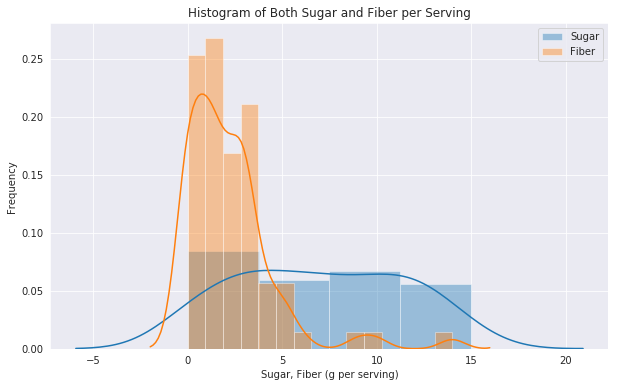

In [34]:
# Histogram of sugar and fiber per serving
plt.figure(figsize=(10, 6))
sns.distplot(cereal["Sugar(g per svg)"])
sns.distplot(cereal["Fiber(g per svg)"])
plt.title("Histogram of Both Sugar and Fiber per Serving")
plt.xlabel("Sugar, Fiber (g per serving)")
plt.ylabel("Frequency")
plt.legend(labels=["Sugar","Fiber"])
plt.show()

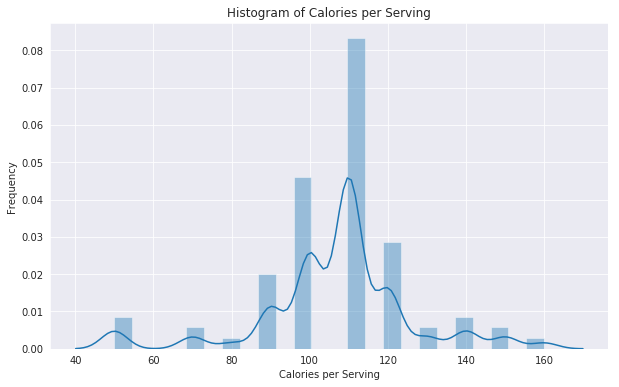

In [13]:
# Histogram of calories per serving 
plt.figure(figsize=(10, 6))
sns.distplot(cereal["Calories(cal per svg)"])
plt.title("Histogram of Calories per Serving")
plt.xlabel("Calories per Serving")
plt.ylabel("Frequency")
plt.show()

In [30]:
# Summary statistics of calories per serving
cereal["Calories(cal per svg)"].describe()

count     76.000000
mean     106.973684
std       19.597261
min       50.000000
25%      100.000000
50%      110.000000
75%      110.000000
max      160.000000
Name: Calories(cal per svg), dtype: float64

## Question 1: Is Consumer Reports average rating (0-100) related to sugar, calories, and fiber per serving?

Line plots of average rating of consumer satisfaction (0-100) show a negative association with sugar and calories per serving and a slightly positive association with fiber per serving. Given the limited sample size, the confidence bounds are wide. 

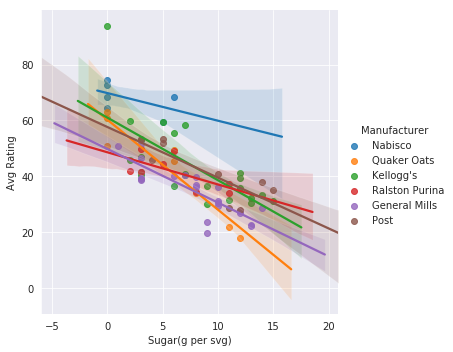

In [38]:
# Line plot of average rating vs. sugar, stratified by manufacturer
sns.lmplot(x="Sugar(g per svg)", y="Avg Rating", data=cereal, hue="Manufacturer")

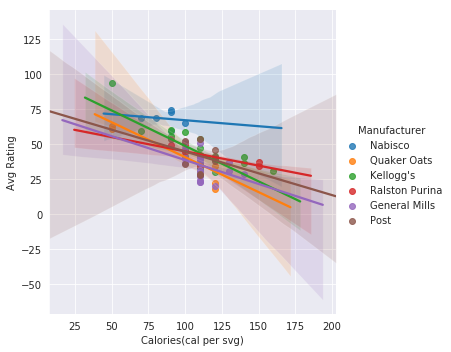

In [39]:
# Line plot of average rating vs. calories, stratified by manufacturer
sns.lmplot(x="Calories(cal per svg)", y="Avg Rating", data=cereal, hue="Manufacturer")

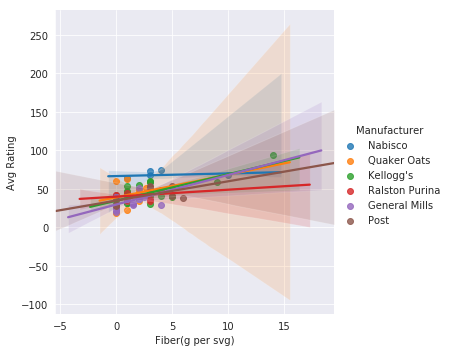

In [40]:
# Line plot of average rating vs. fiber, stratified by manufacturer
sns.lmplot(x="Fiber(g per svg)", y="Avg Rating", data=cereal, hue="Manufacturer")

Looking at the Pearson correlation of key variables, it looks like there's a moderately strong negative correlation between average rating and calories per serving (-0.69) and average rating and sugar per serving (-0.76) and a moderately strong positive correlation between average rating and fiber per serving (0.60). 

[Text(0.5, 0, 'Avg Rating'),
 Text(1.5, 0, 'Calories(cal per svg)'),
 Text(2.5, 0, 'Sugar(g per svg)'),
 Text(3.5, 0, 'Fiber(g per svg)'),
 Text(4.5, 0, 'Sodium(mg per svg)')]

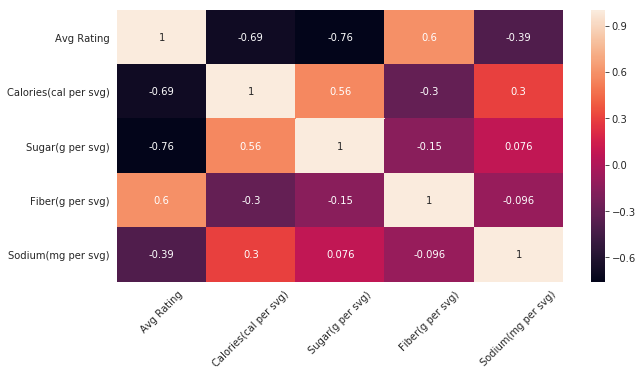

In [41]:
# Heatmap of Pearson correlation between key variables  
plt.figure(figsize=(10,5))
cereal_corr=cereal.loc[:,["Avg Rating", "Calories(cal per svg)", "Sugar(g per svg)", "Fiber(g per svg)", "Sodium(mg per svg)"]]
g = sns.heatmap(cereal_corr.corr(), annot=True)
g.set_xticklabels(g.get_xticklabels(),rotation=45)

## Question 2: What are the sugar and calorie per serving and average rating differences by manufacturer?

Box plots across manufacturers reveal varying spreads and median sugar and calories per serving and average rating by manufacturer. Nabisco and Quaker Oats have lower median sugar and calories per serving, while drawing higher average ratings from consumers. Vice versa for Post. 

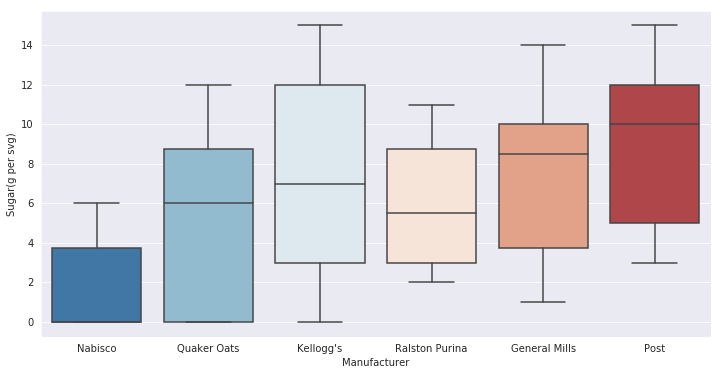

In [43]:
# Box plot of sugar per serving by manufacturer
plt.figure(figsize=(12, 6))
sns.boxplot(cereal["Manufacturer"], cereal["Sugar(g per svg)"], palette = "RdBu_r")

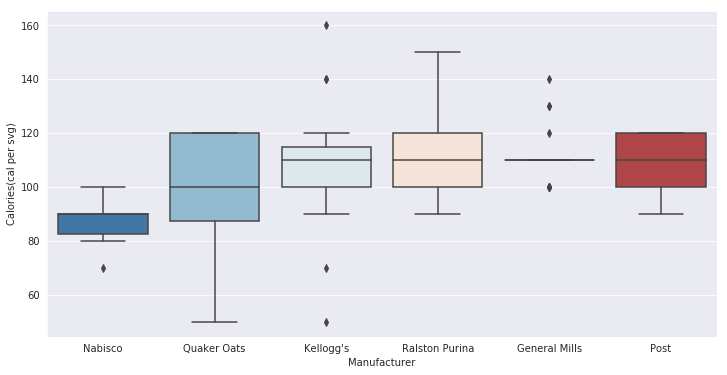

In [42]:
# Box plot of calories per serving by manufacturer
plt.figure(figsize=(12, 6))
sns.boxplot(cereal["Manufacturer"], cereal["Calories(cal per svg)"], palette = "RdBu_r")

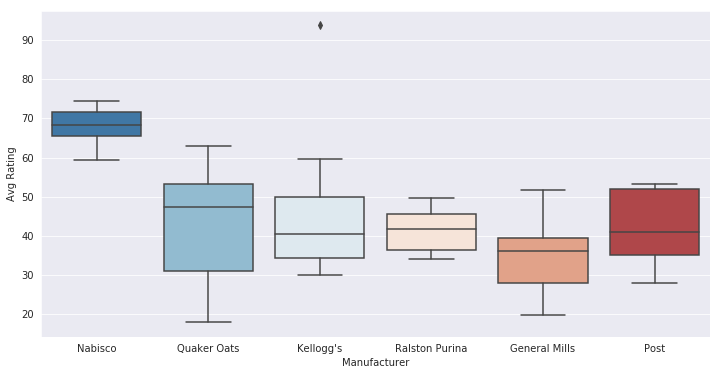

In [44]:
# Box plot of average rating by manufacturer
plt.figure(figsize=(12, 6))
sns.boxplot(cereal["Manufacturer"], cereal["Avg Rating"], palette = "RdBu_r")

The 10 most sugary brands include familiar ones like Golden Crisp, Smacks, Apple Jacks, Cocao Puffs, Froot Loops, and Cap'n'Crunch and are dominated by Post, Kellogg's, and General Mills. 

In [48]:
# 10 highest-sugar per serving cereal brands
cereal.nlargest(10, "Sugar(g per svg)")

,Name,Manufacturer,Type,Calories(cal per svg),Protein(g per svg),Fat(g per svg),Sodium(mg per svg),Fiber(g per svg),Complex Carbs(g per svg),Sugar(g per svg),Potassium(mg per svg),Vitamins(% daily per svg),Shelf(from bottom),Weight(oz per svg),Cups(cups per svg),Avg Rating
30,Golden Crisp,Post,Cold,100,2,0,45,0.0,11.0,15,40,25,1,1.00,0.88,35.252444
66,Smacks,Kellogg's,Cold,110,2,1,70,1.0,9.0,15,40,25,2,1.00,0.75,31.230054
6,Apple Jacks,Kellogg's,Cold,110,2,0,125,1.0,11.0,14,30,25,2,1.00,1.00,33.174094
52,Post Nat. Raisin Bran,Post,Cold,120,3,1,200,6.0,11.0,14,260,25,3,1.33,0.67,37.840594
70,Total Raisin Bran,General Mills,Cold,140,3,1,190,4.0,15.0,14,230,100,3,1.50,1.00,28.592785
14,Cocoa Puffs,General Mills,Cold,110,1,1,180,0.0,12.0,13,55,25,2,1.00,1.00,22.736446
18,Count Chocula,General Mills,Cold,110,1,1,180,0.0,12.0,13,65,25,2,1.00,1.00,22.396513
24,Froot Loops,Kellogg's,Cold,110,2,1,125,1.0,11.0,13,30,25,2,1.00,1.00,32.207582
46,Mueslix Crispy Blend,Kellogg's,Cold,160,3,2,150,3.0,17.0,13,160,25,3,1.50,0.67,30.313351
10,Cap'n'Crunch,Quaker Oats,Cold,120,1,2,220,0.0,12.0,12,35,25,2,1.00,0.75,18.042851


The 10 highest-calorie brands include Mueslix, Meusli Raisins, Total Raisin Bran, Basic 4, and Cap'n'Crunch. 

In [47]:
# 10 highest-calorie per serving cereal brands
cereal.nlargest(10, "Calories(cal per svg)")

,Name,Manufacturer,Type,Calories(cal per svg),Protein(g per svg),Fat(g per svg),Sodium(mg per svg),Fiber(g per svg),Complex Carbs(g per svg),Sugar(g per svg),Potassium(mg per svg),Vitamins(% daily per svg),Shelf(from bottom),Weight(oz per svg),Cups(cups per svg),Avg Rating
46,Mueslix Crispy Blend,Kellogg's,Cold,160,3,2,150,3.0,17.0,13,160,25,3,1.50,0.67,30.313351
44,Muesli Raisins; Dates; & Almonds,Ralston Purina,Cold,150,4,3,95,3.0,16.0,11,170,25,3,1.00,1.00,37.136863
45,Muesli Raisins; Peaches; & Pecans,Ralston Purina,Cold,150,4,3,150,3.0,16.0,11,170,25,3,1.00,1.00,34.139765
39,Just Right Fruit & Nut,Kellogg's,Cold,140,3,1,170,2.0,20.0,9,95,100,3,1.30,0.75,36.471512
49,Nutri-Grain Almond-Raisin,Kellogg's,Cold,140,3,2,220,3.0,21.0,7,130,25,3,1.33,0.67,40.692320
70,Total Raisin Bran,General Mills,Cold,140,3,1,190,4.0,15.0,14,230,100,3,1.50,1.00,28.592785
7,Basic 4,General Mills,Cold,130,3,2,210,2.0,18.0,8,100,25,3,1.33,0.75,37.038562
51,Oatmeal Raisin Crisp,General Mills,Cold,130,3,2,170,1.5,13.5,10,120,25,3,1.25,0.50,30.450843
1,100% Natural Bran,Quaker Oats,Cold,120,3,5,15,2.0,8.0,8,135,0,3,1.00,1.00,33.983679
10,Cap'n'Crunch,Quaker Oats,Cold,120,1,2,220,0.0,12.0,12,35,25,2,1.00,0.75,18.042851


The 10 highest rated cereal brands are those focused on high fiber content and are dominated by Nabisco, Kellogg's, and Quaker Oats. 

In [50]:
# 10 highest rated cereal brands
cereal.nlargest(10, "Avg Rating")

,Name,Manufacturer,Type,Calories(cal per svg),Protein(g per svg),Fat(g per svg),Sodium(mg per svg),Fiber(g per svg),Complex Carbs(g per svg),Sugar(g per svg),Potassium(mg per svg),Vitamins(% daily per svg),Shelf(from bottom),Weight(oz per svg),Cups(cups per svg),Avg Rating
3,All-Bran with Extra Fiber,Kellogg's,Cold,50,4,0,140,14.0,8.0,0,330,25,3,1.00,0.50,93.704912
64,Shredded Wheat 'n'Bran,Nabisco,Cold,90,3,0,0,4.0,19.0,0,140,0,1,1.00,0.67,74.472949
65,Shredded Wheat spoon size,Nabisco,Cold,90,3,0,0,3.0,20.0,0,120,0,1,1.00,0.67,72.801787
0,100% Bran,Nabisco,Cold,70,4,1,130,10.0,5.0,6,280,25,3,1.00,0.33,68.402973
63,Shredded Wheat,Nabisco,Cold,80,2,0,0,3.0,16.0,0,95,0,1,0.83,1.00,68.235885
20,Cream of Wheat (Quick),Nabisco,Hot,100,3,0,80,1.0,21.0,0,0,0,2,1.00,1.00,64.533816
55,Puffed Wheat,Quaker Oats,Cold,50,2,0,0,1.0,10.0,0,50,0,3,0.50,1.00,63.005645
54,Puffed Rice,Quaker Oats,Cold,50,1,0,0,0.0,13.0,0,15,0,3,0.50,1.00,60.756112
50,Nutri-grain Wheat,Kellogg's,Cold,90,3,0,170,3.0,18.0,2,90,25,3,1.00,1.00,59.642837
2,All-Bran,Kellogg's,Cold,70,4,1,260,9.0,7.0,5,320,25,3,1.00,0.33,59.425505


Below, we group mean sugar per serving and average rating by manufacturer. 

In [51]:
cereal.groupby("Manufacturer").agg({"Sugar(g per svg)":[np.mean]})

,Sugar(g per svg)
,mean
Manufacturer,
General Mills,7.954545
Kellogg's,7.565217
Nabisco,1.833333
Post,8.777778
Quaker Oats,5.375000
Ralston Purina,6.125000


In [23]:
cereal.groupby("Manufacturer").agg({"Avg Rating":[np.mean, np.std]})

Avg Rating           
                     mean        std
Manufacturer                        
General Mills   34.485852   8.946704
Kellogg's       44.038462  14.457434
Nabisco         67.968567   5.509326
Post            41.705744  10.047647
Quaker Oats     42.915990  16.797673
Ralston Purina  41.542997   6.080841

## Question 3: Is sugar per serving related to shelf position (from bottom)? 

Box plots of sugar per serving by shelf position with 1 being bottom, 2 being middle, and 3 being top, reveal that the middle shelf most visible and accessible to kids houses brands with the highest median, 25th percentile, and 75th percentile sugar per serving. 

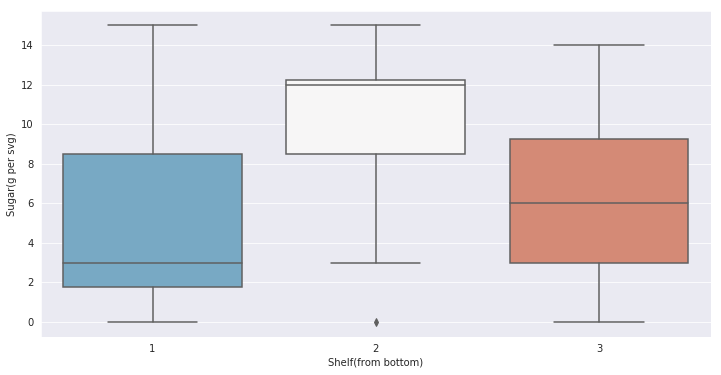

In [45]:
# Box plot of sugar per serving by shelf position (from bottom)
plt.figure(figsize=(12, 6))
sns.boxplot(cereal["Shelf(from bottom)"], cereal["Sugar(g per svg)"], palette = "RdBu_r")

Mean sugar per serving among cereal brands on the middle shelf is roughly twice that of the bottom shelf. 

In [46]:
# Mean sugar per serving by shelf position
cereal.groupby("Shelf(from bottom)").agg({"Sugar(g per svg)":[np.mean]})

,Sugar(g per svg)
,mean
Shelf(from bottom),
1,4.850000
2,9.950000
3,6.527778
